<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:49] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


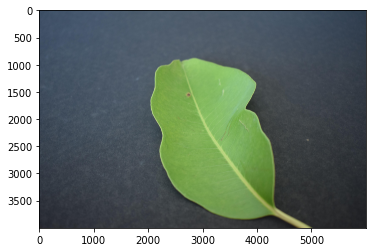

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

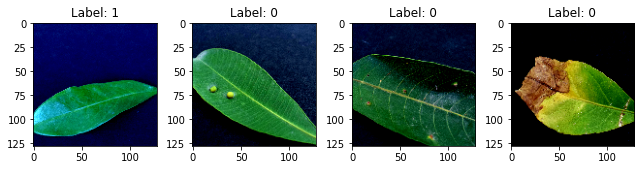

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:55] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:57] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.248131657930775 samples/sec                   batch loss = 0.43766671419143677 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.257086314195002 samples/sec                   batch loss = 0.5621263384819031 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2551315944806343 samples/sec                   batch loss = 1.2104370594024658 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2588368428295245 samples/sec                   batch loss = 1.1495344638824463 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2224171678582962 samples/sec                   batch loss = 1.1199779510498047 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2609151328686212 samples/sec                   batch loss = 0.6939402222633362 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2575626310896781 samples/sec                   batch loss = 0.5838817358016968 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.263031103123803 samples/sec                   batch loss = 0.511647641658783 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2650143400879066 samples/sec                   batch loss = 0.446643590927124 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.2672654671320422 samples/sec                   batch loss = 0.4810234010219574 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2667563308498122 samples/sec                   batch loss = 0.5589098930358887 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2616487627699216 samples/sec                   batch loss = 0.4918134808540344 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2717615713879844 samples/sec                   batch loss = 0.2559483051300049 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2690661746290335 samples/sec                   batch loss = 0.594183623790741 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.26706027072161 samples/sec                   batch loss = 0.43230509757995605 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.263247361535882 samples/sec                   batch loss = 0.5814141631126404 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.2632341404490164 samples/sec                   batch loss = 0.33075690269470215 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2663571351365386 samples/sec                   batch loss = 0.647678554058075 | accuracy = 0.6166666666666667


Epoch[1] Batch[95] Speed: 1.2728399837613897 samples/sec                   batch loss = 0.410027414560318 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2696251116309012 samples/sec                   batch loss = 1.0770677328109741 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2561834811415795 samples/sec                   batch loss = 1.2850263118743896 | accuracy = 0.6238095238095238


Epoch[1] Batch[110] Speed: 1.2600931962753334 samples/sec                   batch loss = 0.26284030079841614 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.266395944082738 samples/sec                   batch loss = 0.5225841403007507 | accuracy = 0.6391304347826087


Epoch[1] Batch[120] Speed: 1.265920937136143 samples/sec                   batch loss = 0.51174396276474 | accuracy = 0.6479166666666667


Epoch[1] Batch[125] Speed: 1.2674619207274234 samples/sec                   batch loss = 0.4653310179710388 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2637165563267079 samples/sec                   batch loss = 1.2052479982376099 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2644241947246975 samples/sec                   batch loss = 0.8067600727081299 | accuracy = 0.6518518518518519


Epoch[1] Batch[140] Speed: 1.270251378883011 samples/sec                   batch loss = 0.7885060906410217 | accuracy = 0.6571428571428571


Epoch[1] Batch[145] Speed: 1.2659175939530105 samples/sec                   batch loss = 0.49788013100624084 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2641160889232472 samples/sec                   batch loss = 0.48489078879356384 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.265445713703853 samples/sec                   batch loss = 1.2437000274658203 | accuracy = 0.6645161290322581


Epoch[1] Batch[160] Speed: 1.2734574413983335 samples/sec                   batch loss = 0.279462605714798 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.2683168962779305 samples/sec                   batch loss = 0.28702935576438904 | accuracy = 0.6651515151515152


Epoch[1] Batch[170] Speed: 1.2667656085681995 samples/sec                   batch loss = 0.8652608394622803 | accuracy = 0.663235294117647


Epoch[1] Batch[175] Speed: 1.265565130504962 samples/sec                   batch loss = 0.6563123464584351 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.2632425106013647 samples/sec                   batch loss = 1.1925406455993652 | accuracy = 0.6625


Epoch[1] Batch[185] Speed: 1.2653623930268925 samples/sec                   batch loss = 0.555289626121521 | accuracy = 0.6608108108108108


Epoch[1] Batch[190] Speed: 1.2663848555696742 samples/sec                   batch loss = 0.6214727759361267 | accuracy = 0.6618421052631579


Epoch[1] Batch[195] Speed: 1.2671577881542173 samples/sec                   batch loss = 0.45536768436431885 | accuracy = 0.6628205128205128


Epoch[1] Batch[200] Speed: 1.262313435530976 samples/sec                   batch loss = 0.4661361873149872 | accuracy = 0.66875


Epoch[1] Batch[205] Speed: 1.2656892485846711 samples/sec                   batch loss = 0.6312837600708008 | accuracy = 0.6719512195121952


Epoch[1] Batch[210] Speed: 1.2586722315512964 samples/sec                   batch loss = 0.4154224097728729 | accuracy = 0.6714285714285714


Epoch[1] Batch[215] Speed: 1.268957613564458 samples/sec                   batch loss = 0.7663934230804443 | accuracy = 0.6755813953488372


Epoch[1] Batch[220] Speed: 1.2695465233964869 samples/sec                   batch loss = 0.6891913414001465 | accuracy = 0.6715909090909091


Epoch[1] Batch[225] Speed: 1.2616717232151828 samples/sec                   batch loss = 0.6667852401733398 | accuracy = 0.67


Epoch[1] Batch[230] Speed: 1.262461900696689 samples/sec                   batch loss = 0.33617573976516724 | accuracy = 0.6717391304347826


Epoch[1] Batch[235] Speed: 1.2688383234003915 samples/sec                   batch loss = 0.38499847054481506 | accuracy = 0.675531914893617


Epoch[1] Batch[240] Speed: 1.2692558891179258 samples/sec                   batch loss = 0.5322691202163696 | accuracy = 0.6739583333333333


Epoch[1] Batch[245] Speed: 1.2629134949644072 samples/sec                   batch loss = 1.3182377815246582 | accuracy = 0.6704081632653062


Epoch[1] Batch[250] Speed: 1.2538843607200314 samples/sec                   batch loss = 0.5607426762580872 | accuracy = 0.668


Epoch[1] Batch[255] Speed: 1.2661494616726618 samples/sec                   batch loss = 0.4183940291404724 | accuracy = 0.6686274509803921


Epoch[1] Batch[260] Speed: 1.2601203592104209 samples/sec                   batch loss = 0.22548724710941315 | accuracy = 0.6682692307692307


Epoch[1] Batch[265] Speed: 1.2550063463889616 samples/sec                   batch loss = 0.41726750135421753 | accuracy = 0.6679245283018868


Epoch[1] Batch[270] Speed: 1.262620853167597 samples/sec                   batch loss = 0.6807867288589478 | accuracy = 0.6638888888888889


Epoch[1] Batch[275] Speed: 1.2640622763225506 samples/sec                   batch loss = 0.6102604866027832 | accuracy = 0.6654545454545454


Epoch[1] Batch[280] Speed: 1.263477585968764 samples/sec                   batch loss = 0.5431646704673767 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2667182649331643 samples/sec                   batch loss = 0.7339802384376526 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.2651246124535915 samples/sec                   batch loss = 0.2837930917739868 | accuracy = 0.6663793103448276


Epoch[1] Batch[295] Speed: 1.2675664910415474 samples/sec                   batch loss = 0.4493967294692993 | accuracy = 0.6669491525423729


Epoch[1] Batch[300] Speed: 1.2716773205633116 samples/sec                   batch loss = 0.9645024538040161 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.268989863188059 samples/sec                   batch loss = 0.4563400447368622 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2701257875443122 samples/sec                   batch loss = 0.6120057106018066 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.2637779551813175 samples/sec                   batch loss = 0.383960485458374 | accuracy = 0.6706349206349206


Epoch[1] Batch[320] Speed: 1.2527498801364454 samples/sec                   batch loss = 0.6059904098510742 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.2615907012404892 samples/sec                   batch loss = 0.7874287366867065 | accuracy = 0.6684615384615384


Epoch[1] Batch[330] Speed: 1.2675979038097713 samples/sec                   batch loss = 0.49586212635040283 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.256137301369342 samples/sec                   batch loss = 0.657463550567627 | accuracy = 0.6716417910447762


Epoch[1] Batch[340] Speed: 1.2592685498032161 samples/sec                   batch loss = 0.746986985206604 | accuracy = 0.6727941176470589


Epoch[1] Batch[345] Speed: 1.2607743265555091 samples/sec                   batch loss = 0.6541761755943298 | accuracy = 0.672463768115942


Epoch[1] Batch[350] Speed: 1.2655150127960424 samples/sec                   batch loss = 0.6637605428695679 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.259421215685774 samples/sec                   batch loss = 0.3408184349536896 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.2759653941527815 samples/sec                   batch loss = 0.34235256910324097 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.263716175577231 samples/sec                   batch loss = 0.36433538794517517 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2707985582602168 samples/sec                   batch loss = 0.19378413259983063 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.267939139100285 samples/sec                   batch loss = 0.742478609085083 | accuracy = 0.6733333333333333


Epoch[1] Batch[380] Speed: 1.2582088502307525 samples/sec                   batch loss = 0.8224034905433655 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2530249553918553 samples/sec                   batch loss = 0.2594357132911682 | accuracy = 0.6746753246753247


Epoch[1] Batch[390] Speed: 1.2595995460484806 samples/sec                   batch loss = 0.5162637233734131 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.2611888760318488 samples/sec                   batch loss = 0.5512933135032654 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2574363319097512 samples/sec                   batch loss = 0.3212854564189911 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.266069583350973 samples/sec                   batch loss = 0.3632792830467224 | accuracy = 0.6777777777777778


Epoch[1] Batch[410] Speed: 1.2686164054934912 samples/sec                   batch loss = 0.6049837470054626 | accuracy = 0.6780487804878049


Epoch[1] Batch[415] Speed: 1.2604952705176453 samples/sec                   batch loss = 0.1907608062028885 | accuracy = 0.6771084337349398


Epoch[1] Batch[420] Speed: 1.2604459323213033 samples/sec                   batch loss = 0.39118027687072754 | accuracy = 0.675


Epoch[1] Batch[425] Speed: 1.2654830349991277 samples/sec                   batch loss = 0.5527751445770264 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.2598033734842775 samples/sec                   batch loss = 0.5517950654029846 | accuracy = 0.6755813953488372


Epoch[1] Batch[435] Speed: 1.2727181281597075 samples/sec                   batch loss = 0.36238524317741394 | accuracy = 0.6770114942528735


Epoch[1] Batch[440] Speed: 1.2658520711282455 samples/sec                   batch loss = 0.4512280523777008 | accuracy = 0.6772727272727272


Epoch[1] Batch[445] Speed: 1.279080446239859 samples/sec                   batch loss = 0.563237726688385 | accuracy = 0.6775280898876405


Epoch[1] Batch[450] Speed: 1.2774273491108339 samples/sec                   batch loss = 0.4773307144641876 | accuracy = 0.6783333333333333


Epoch[1] Batch[455] Speed: 1.2754317916191595 samples/sec                   batch loss = 0.44175878167152405 | accuracy = 0.6791208791208792


Epoch[1] Batch[460] Speed: 1.2632620096818974 samples/sec                   batch loss = 0.5990309119224548 | accuracy = 0.6804347826086956


Epoch[1] Batch[465] Speed: 1.2728848888954305 samples/sec                   batch loss = 0.4844791889190674 | accuracy = 0.6806451612903226


Epoch[1] Batch[470] Speed: 1.2716975628776122 samples/sec                   batch loss = 0.5314135551452637 | accuracy = 0.6819148936170213


Epoch[1] Batch[475] Speed: 1.2714174086835546 samples/sec                   batch loss = 0.24635043740272522 | accuracy = 0.6826315789473684


Epoch[1] Batch[480] Speed: 1.2681855519718455 samples/sec                   batch loss = 1.5417860746383667 | accuracy = 0.6807291666666667


Epoch[1] Batch[485] Speed: 1.2722880543798505 samples/sec                   batch loss = 0.4397622346878052 | accuracy = 0.6804123711340206


Epoch[1] Batch[490] Speed: 1.268259753367966 samples/sec                   batch loss = 0.8982315063476562 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.2729303766807196 samples/sec                   batch loss = 0.7240604162216187 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2696129096410789 samples/sec                   batch loss = 0.45484212040901184 | accuracy = 0.6825


Epoch[1] Batch[505] Speed: 1.2727868742518387 samples/sec                   batch loss = 0.39194804430007935 | accuracy = 0.6831683168316832


Epoch[1] Batch[510] Speed: 1.2695383576954131 samples/sec                   batch loss = 0.2407386749982834 | accuracy = 0.6843137254901961


Epoch[1] Batch[515] Speed: 1.2609919926498574 samples/sec                   batch loss = 0.652567446231842 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.2643831243313408 samples/sec                   batch loss = 1.1839940547943115 | accuracy = 0.6841346153846154


Epoch[1] Batch[525] Speed: 1.2621049023835322 samples/sec                   batch loss = 0.20388779044151306 | accuracy = 0.6847619047619048


Epoch[1] Batch[530] Speed: 1.2699474443668068 samples/sec                   batch loss = 0.504623532295227 | accuracy = 0.6849056603773584


Epoch[1] Batch[535] Speed: 1.2544614233590914 samples/sec                   batch loss = 0.3285611867904663 | accuracy = 0.6869158878504673


Epoch[1] Batch[540] Speed: 1.2648212189893984 samples/sec                   batch loss = 0.5877259373664856 | accuracy = 0.687962962962963


Epoch[1] Batch[545] Speed: 1.2695425846334432 samples/sec                   batch loss = 0.2637210190296173 | accuracy = 0.6876146788990826


Epoch[1] Batch[550] Speed: 1.2656264226986953 samples/sec                   batch loss = 0.7850147485733032 | accuracy = 0.6881818181818182


Epoch[1] Batch[555] Speed: 1.2652977864927033 samples/sec                   batch loss = 0.45647647976875305 | accuracy = 0.6887387387387387


Epoch[1] Batch[560] Speed: 1.2612359968672855 samples/sec                   batch loss = 0.7401639223098755 | accuracy = 0.6883928571428571


Epoch[1] Batch[565] Speed: 1.2698729492463061 samples/sec                   batch loss = 0.4558824896812439 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.2707257919325212 samples/sec                   batch loss = 0.28895488381385803 | accuracy = 0.6894736842105263


Epoch[1] Batch[575] Speed: 1.2701605005838181 samples/sec                   batch loss = 0.30604133009910583 | accuracy = 0.6895652173913044


Epoch[1] Batch[580] Speed: 1.2667276377355094 samples/sec                   batch loss = 0.47629499435424805 | accuracy = 0.690948275862069


Epoch[1] Batch[585] Speed: 1.267714182907259 samples/sec                   batch loss = 0.8560149669647217 | accuracy = 0.691025641025641


Epoch[1] Batch[590] Speed: 1.275828289122375 samples/sec                   batch loss = 0.3442115783691406 | accuracy = 0.6911016949152542


Epoch[1] Batch[595] Speed: 1.2734000276581627 samples/sec                   batch loss = 0.5214976668357849 | accuracy = 0.6911764705882353


Epoch[1] Batch[600] Speed: 1.2677663909232813 samples/sec                   batch loss = 0.23241618275642395 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.2604421445196228 samples/sec                   batch loss = 0.656710147857666 | accuracy = 0.6913223140495868


Epoch[1] Batch[610] Speed: 1.266608383953229 samples/sec                   batch loss = 0.536777675151825 | accuracy = 0.6926229508196722


Epoch[1] Batch[615] Speed: 1.269881888199303 samples/sec                   batch loss = 0.6288425922393799 | accuracy = 0.693089430894309


Epoch[1] Batch[620] Speed: 1.2700066622070276 samples/sec                   batch loss = 0.7401363849639893 | accuracy = 0.6931451612903226


Epoch[1] Batch[625] Speed: 1.2635837838578778 samples/sec                   batch loss = 0.41183167695999146 | accuracy = 0.6944


Epoch[1] Batch[630] Speed: 1.2644919524116385 samples/sec                   batch loss = 0.21563304960727692 | accuracy = 0.6956349206349206


Epoch[1] Batch[635] Speed: 1.2688289193372648 samples/sec                   batch loss = 0.4413352906703949 | accuracy = 0.6960629921259842


Epoch[1] Batch[640] Speed: 1.2704436605965277 samples/sec                   batch loss = 0.5136288404464722 | accuracy = 0.696484375


Epoch[1] Batch[645] Speed: 1.2661536660740618 samples/sec                   batch loss = 0.4103824198246002 | accuracy = 0.6976744186046512


Epoch[1] Batch[650] Speed: 1.2633434367378584 samples/sec                   batch loss = 0.17868764698505402 | accuracy = 0.6988461538461539


Epoch[1] Batch[655] Speed: 1.2666732200325825 samples/sec                   batch loss = 0.19310534000396729 | accuracy = 0.6992366412213741


Epoch[1] Batch[660] Speed: 1.2651037202785138 samples/sec                   batch loss = 0.5458968281745911 | accuracy = 0.6996212121212121


Epoch[1] Batch[665] Speed: 1.270141461064045 samples/sec                   batch loss = 0.35709860920906067 | accuracy = 0.6992481203007519


Epoch[1] Batch[670] Speed: 1.2684485554978602 samples/sec                   batch loss = 0.4254937767982483 | accuracy = 0.6985074626865672


Epoch[1] Batch[675] Speed: 1.2574093788026457 samples/sec                   batch loss = 1.0218952894210815 | accuracy = 0.6992592592592592


Epoch[1] Batch[680] Speed: 1.2633404876776377 samples/sec                   batch loss = 0.46738889813423157 | accuracy = 0.6996323529411764


Epoch[1] Batch[685] Speed: 1.266456551973192 samples/sec                   batch loss = 0.4569597542285919 | accuracy = 0.7


Epoch[1] Batch[690] Speed: 1.2676004896862683 samples/sec                   batch loss = 0.31405121088027954 | accuracy = 0.7


Epoch[1] Batch[695] Speed: 1.2666919644427828 samples/sec                   batch loss = 0.642383873462677 | accuracy = 0.6985611510791367


Epoch[1] Batch[700] Speed: 1.2585283382021257 samples/sec                   batch loss = 0.46881821751594543 | accuracy = 0.6978571428571428


Epoch[1] Batch[705] Speed: 1.2641034211199675 samples/sec                   batch loss = 0.4034233093261719 | accuracy = 0.6985815602836879


Epoch[1] Batch[710] Speed: 1.2632337599901815 samples/sec                   batch loss = 0.523199737071991 | accuracy = 0.698943661971831


Epoch[1] Batch[715] Speed: 1.2653638245610013 samples/sec                   batch loss = 0.5862202048301697 | accuracy = 0.6979020979020979


Epoch[1] Batch[720] Speed: 1.2703692034424994 samples/sec                   batch loss = 0.4825890064239502 | accuracy = 0.6975694444444445


Epoch[1] Batch[725] Speed: 1.2644131407137222 samples/sec                   batch loss = 0.41720476746559143 | accuracy = 0.6986206896551724


Epoch[1] Batch[730] Speed: 1.2744744446361285 samples/sec                   batch loss = 0.5862494707107544 | accuracy = 0.6986301369863014


Epoch[1] Batch[735] Speed: 1.2714992159808045 samples/sec                   batch loss = 0.4113648533821106 | accuracy = 0.6993197278911565


Epoch[1] Batch[740] Speed: 1.2660128338257493 samples/sec                   batch loss = 0.5562655329704285 | accuracy = 0.7


Epoch[1] Batch[745] Speed: 1.2641585707785186 samples/sec                   batch loss = 0.4257129430770874 | accuracy = 0.6996644295302014


Epoch[1] Batch[750] Speed: 1.2654822713700034 samples/sec                   batch loss = 0.49380970001220703 | accuracy = 0.7


Epoch[1] Batch[755] Speed: 1.2676137065531317 samples/sec                   batch loss = 0.39982762932777405 | accuracy = 0.6993377483443709


Epoch[1] Batch[760] Speed: 1.2663994809768897 samples/sec                   batch loss = 0.41745588183403015 | accuracy = 0.7006578947368421


Epoch[1] Batch[765] Speed: 1.2628765151951964 samples/sec                   batch loss = 0.3689354360103607 | accuracy = 0.7013071895424836


Epoch[1] Batch[770] Speed: 1.2594543060516388 samples/sec                   batch loss = 0.3224652409553528 | accuracy = 0.7012987012987013


Epoch[1] Batch[775] Speed: 1.2643204280412215 samples/sec                   batch loss = 1.2047560214996338 | accuracy = 0.6996774193548387


Epoch[1] Batch[780] Speed: 1.2698105723141264 samples/sec                   batch loss = 0.7641651034355164 | accuracy = 0.6993589743589743


Epoch[1] Batch[785] Speed: 1.2649211577562636 samples/sec                   batch loss = 0.43963080644607544 | accuracy = 0.6980891719745222


[Epoch 1] training: accuracy=0.6976522842639594
[Epoch 1] time cost: 645.4534232616425
[Epoch 1] validation: validation accuracy=0.7144444444444444


Epoch[2] Batch[5] Speed: 1.2724561500509637 samples/sec                   batch loss = 0.5038943290710449 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2647293998647162 samples/sec                   batch loss = 0.2350907176733017 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2635544729794723 samples/sec                   batch loss = 0.8634404540061951 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2731026996001202 samples/sec                   batch loss = 0.22912441194057465 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2731129399864396 samples/sec                   batch loss = 0.3866994082927704 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2699461946991613 samples/sec                   batch loss = 0.401191771030426 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.269174178201955 samples/sec                   batch loss = 0.19654688239097595 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.276512943577211 samples/sec                   batch loss = 0.23099541664123535 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.2715894185598278 samples/sec                   batch loss = 0.3495640456676483 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2715848888516328 samples/sec                   batch loss = 0.7170523405075073 | accuracy = 0.79


Epoch[2] Batch[55] Speed: 1.2735991614409818 samples/sec                   batch loss = 0.5202314257621765 | accuracy = 0.7909090909090909


Epoch[2] Batch[60] Speed: 1.2691611207932014 samples/sec                   batch loss = 0.20699888467788696 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2663316142935048 samples/sec                   batch loss = 0.39676421880722046 | accuracy = 0.7730769230769231


Epoch[2] Batch[70] Speed: 1.271707395091365 samples/sec                   batch loss = 0.32850444316864014 | accuracy = 0.775


Epoch[2] Batch[75] Speed: 1.2739327049934983 samples/sec                   batch loss = 0.1355135440826416 | accuracy = 0.7766666666666666


Epoch[2] Batch[80] Speed: 1.2698126866860602 samples/sec                   batch loss = 1.0310027599334717 | accuracy = 0.775


Epoch[2] Batch[85] Speed: 1.265427197049602 samples/sec                   batch loss = 0.7765539884567261 | accuracy = 0.7705882352941177


Epoch[2] Batch[90] Speed: 1.2719116889051867 samples/sec                   batch loss = 0.5961114764213562 | accuracy = 0.7722222222222223


Epoch[2] Batch[95] Speed: 1.2691073578231515 samples/sec                   batch loss = 0.31047552824020386 | accuracy = 0.7736842105263158


Epoch[2] Batch[100] Speed: 1.2767656154255227 samples/sec                   batch loss = 1.1488856077194214 | accuracy = 0.77


Epoch[2] Batch[105] Speed: 1.2628025621532926 samples/sec                   batch loss = 0.4123309552669525 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2637433997430967 samples/sec                   batch loss = 0.1497727483510971 | accuracy = 0.7659090909090909


Epoch[2] Batch[115] Speed: 1.2745104608104665 samples/sec                   batch loss = 0.3335507810115814 | accuracy = 0.7608695652173914


Epoch[2] Batch[120] Speed: 1.273512250252828 samples/sec                   batch loss = 0.6295273303985596 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2736698399062338 samples/sec                   batch loss = 0.33045852184295654 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2666148863873834 samples/sec                   batch loss = 0.38525331020355225 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2732969085702321 samples/sec                   batch loss = 0.5143916010856628 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.2775694677545222 samples/sec                   batch loss = 0.3169538974761963 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.2688158690316338 samples/sec                   batch loss = 0.30994710326194763 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.267823393575769 samples/sec                   batch loss = 0.3652639389038086 | accuracy = 0.7383333333333333


Epoch[2] Batch[155] Speed: 1.2644101866573094 samples/sec                   batch loss = 0.3479582369327545 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2728077312761712 samples/sec                   batch loss = 0.5459168553352356 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.2715027814381021 samples/sec                   batch loss = 0.6179937124252319 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.2718099676415442 samples/sec                   batch loss = 0.47340354323387146 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.2608768486315676 samples/sec                   batch loss = 0.2227841019630432 | accuracy = 0.7457142857142857


Epoch[2] Batch[180] Speed: 1.2646198636456283 samples/sec                   batch loss = 0.2957562506198883 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.2657391891104828 samples/sec                   batch loss = 0.7201471924781799 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2760567168229524 samples/sec                   batch loss = 0.4361725449562073 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2770387028248855 samples/sec                   batch loss = 0.5890249013900757 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.2647235841489817 samples/sec                   batch loss = 0.3421836197376251 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.2708754724721933 samples/sec                   batch loss = 0.4187365174293518 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.2695299999689753 samples/sec                   batch loss = 0.6575298309326172 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.272419284856024 samples/sec                   batch loss = 0.6841707229614258 | accuracy = 0.7558139534883721


Epoch[2] Batch[220] Speed: 1.2729984695685428 samples/sec                   batch loss = 0.34926432371139526 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.2733573090087296 samples/sec                   batch loss = 0.6074178218841553 | accuracy = 0.7555555555555555


Epoch[2] Batch[230] Speed: 1.2690949737844528 samples/sec                   batch loss = 0.4223426282405853 | accuracy = 0.7565217391304347


Epoch[2] Batch[235] Speed: 1.2711044412091648 samples/sec                   batch loss = 0.561707079410553 | accuracy = 0.7563829787234042


Epoch[2] Batch[240] Speed: 1.276682157567351 samples/sec                   batch loss = 0.6371039748191833 | accuracy = 0.7583333333333333


Epoch[2] Batch[245] Speed: 1.2670517542100777 samples/sec                   batch loss = 0.7362009882926941 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2612202579270098 samples/sec                   batch loss = 0.26845860481262207 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.2674591439121383 samples/sec                   batch loss = 0.16338633000850677 | accuracy = 0.7617647058823529


Epoch[2] Batch[260] Speed: 1.2713557470079346 samples/sec                   batch loss = 0.28327733278274536 | accuracy = 0.7596153846153846


Epoch[2] Batch[265] Speed: 1.2677737674483838 samples/sec                   batch loss = 0.4152708947658539 | accuracy = 0.7584905660377359


Epoch[2] Batch[270] Speed: 1.2739418946613887 samples/sec                   batch loss = 0.3055613040924072 | accuracy = 0.7611111111111111


Epoch[2] Batch[275] Speed: 1.2667954512231512 samples/sec                   batch loss = 0.43854498863220215 | accuracy = 0.7618181818181818


Epoch[2] Batch[280] Speed: 1.2718836295666343 samples/sec                   batch loss = 1.4442033767700195 | accuracy = 0.7598214285714285


Epoch[2] Batch[285] Speed: 1.2686095947148122 samples/sec                   batch loss = 0.6213746666908264 | accuracy = 0.7605263157894737


Epoch[2] Batch[290] Speed: 1.2700703083156852 samples/sec                   batch loss = 0.18391060829162598 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.2611342695689596 samples/sec                   batch loss = 0.2900899052619934 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.2687531161640937 samples/sec                   batch loss = 0.4846445918083191 | accuracy = 0.7641666666666667


Epoch[2] Batch[305] Speed: 1.264418286522373 samples/sec                   batch loss = 0.31399399042129517 | accuracy = 0.7672131147540984


Epoch[2] Batch[310] Speed: 1.2652998858627769 samples/sec                   batch loss = 0.33009105920791626 | accuracy = 0.7677419354838709


Epoch[2] Batch[315] Speed: 1.2679042599130215 samples/sec                   batch loss = 0.830622136592865 | accuracy = 0.7674603174603175


Epoch[2] Batch[320] Speed: 1.2645456109782582 samples/sec                   batch loss = 0.5883305668830872 | accuracy = 0.7671875


Epoch[2] Batch[325] Speed: 1.2642000076256419 samples/sec                   batch loss = 0.7278870344161987 | accuracy = 0.7653846153846153


Epoch[2] Batch[330] Speed: 1.2719242244049678 samples/sec                   batch loss = 0.4801284372806549 | accuracy = 0.7651515151515151


Epoch[2] Batch[335] Speed: 1.2716693202072453 samples/sec                   batch loss = 0.4861147105693817 | accuracy = 0.7671641791044777


Epoch[2] Batch[340] Speed: 1.2677024965642434 samples/sec                   batch loss = 0.5190555453300476 | accuracy = 0.7639705882352941


Epoch[2] Batch[345] Speed: 1.2581921488230838 samples/sec                   batch loss = 1.3459268808364868 | accuracy = 0.7623188405797101


Epoch[2] Batch[350] Speed: 1.2656880072833647 samples/sec                   batch loss = 0.2550048232078552 | accuracy = 0.7642857142857142


Epoch[2] Batch[355] Speed: 1.2693158107412983 samples/sec                   batch loss = 0.6115690469741821 | accuracy = 0.7626760563380282


Epoch[2] Batch[360] Speed: 1.267472645093795 samples/sec                   batch loss = 0.885970413684845 | accuracy = 0.7631944444444444


Epoch[2] Batch[365] Speed: 1.2648906404273657 samples/sec                   batch loss = 0.2083788514137268 | accuracy = 0.763013698630137


Epoch[2] Batch[370] Speed: 1.261127918082539 samples/sec                   batch loss = 0.3444446623325348 | accuracy = 0.7621621621621621


Epoch[2] Batch[375] Speed: 1.2698719880760578 samples/sec                   batch loss = 1.1268820762634277 | accuracy = 0.7626666666666667


Epoch[2] Batch[380] Speed: 1.2715762150323886 samples/sec                   batch loss = 0.6867716312408447 | accuracy = 0.7618421052631579


Epoch[2] Batch[385] Speed: 1.2688704709954481 samples/sec                   batch loss = 0.3460772633552551 | accuracy = 0.7603896103896104


Epoch[2] Batch[390] Speed: 1.264083896055773 samples/sec                   batch loss = 0.33563899993896484 | accuracy = 0.7621794871794871


Epoch[2] Batch[395] Speed: 1.2714759928158021 samples/sec                   batch loss = 0.4239981770515442 | accuracy = 0.7620253164556962


Epoch[2] Batch[400] Speed: 1.2728457777941988 samples/sec                   batch loss = 0.4835650324821472 | accuracy = 0.760625


Epoch[2] Batch[405] Speed: 1.2703091823234782 samples/sec                   batch loss = 0.692130982875824 | accuracy = 0.7598765432098765


Epoch[2] Batch[410] Speed: 1.270133576177546 samples/sec                   batch loss = 0.6530657410621643 | accuracy = 0.7597560975609756


Epoch[2] Batch[415] Speed: 1.2637077039607165 samples/sec                   batch loss = 0.11300080269575119 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2685266241990056 samples/sec                   batch loss = 0.8668034672737122 | accuracy = 0.7595238095238095


Epoch[2] Batch[425] Speed: 1.2618353168544492 samples/sec                   batch loss = 0.659977912902832 | accuracy = 0.758235294117647


Epoch[2] Batch[430] Speed: 1.2714180831411996 samples/sec                   batch loss = 0.7076210379600525 | accuracy = 0.7558139534883721


Epoch[2] Batch[435] Speed: 1.2636994228273888 samples/sec                   batch loss = 0.8788891434669495 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2624627556836054 samples/sec                   batch loss = 0.3386709988117218 | accuracy = 0.7545454545454545


Epoch[2] Batch[445] Speed: 1.2631371308672876 samples/sec                   batch loss = 0.4402875602245331 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2661511816516777 samples/sec                   batch loss = 0.5123094916343689 | accuracy = 0.7527777777777778


Epoch[2] Batch[455] Speed: 1.269821528681347 samples/sec                   batch loss = 0.38273394107818604 | accuracy = 0.7527472527472527


Epoch[2] Batch[460] Speed: 1.2712570044396811 samples/sec                   batch loss = 0.9701666235923767 | accuracy = 0.7521739130434782


Epoch[2] Batch[465] Speed: 1.2635388664431684 samples/sec                   batch loss = 0.3879967927932739 | accuracy = 0.7521505376344086


Epoch[2] Batch[470] Speed: 1.2640603715356888 samples/sec                   batch loss = 0.29184314608573914 | accuracy = 0.752127659574468


Epoch[2] Batch[475] Speed: 1.2685264323722387 samples/sec                   batch loss = 0.6127227544784546 | accuracy = 0.751578947368421


Epoch[2] Batch[480] Speed: 1.2687210704579943 samples/sec                   batch loss = 0.8118398189544678 | accuracy = 0.7520833333333333


Epoch[2] Batch[485] Speed: 1.2635918731384252 samples/sec                   batch loss = 0.14720596373081207 | accuracy = 0.7515463917525773


Epoch[2] Batch[490] Speed: 1.2672540762235545 samples/sec                   batch loss = 0.5880407691001892 | accuracy = 0.7494897959183674


Epoch[2] Batch[495] Speed: 1.272447271327059 samples/sec                   batch loss = 0.24933485686779022 | accuracy = 0.75


Epoch[2] Batch[500] Speed: 1.2688287274190608 samples/sec                   batch loss = 0.38873839378356934 | accuracy = 0.7505


Epoch[2] Batch[505] Speed: 1.2671095539072006 samples/sec                   batch loss = 0.6689140200614929 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.2618134892646078 samples/sec                   batch loss = 0.08857783675193787 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.2694544972213022 samples/sec                   batch loss = 0.16105785965919495 | accuracy = 0.7509708737864078


Epoch[2] Batch[520] Speed: 1.2713206795980474 samples/sec                   batch loss = 0.48545289039611816 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.2652955917041662 samples/sec                   batch loss = 0.7790890336036682 | accuracy = 0.7495238095238095


Epoch[2] Batch[530] Speed: 1.274926149540825 samples/sec                   batch loss = 0.6266342401504517 | accuracy = 0.7495283018867924


Epoch[2] Batch[535] Speed: 1.2611652695327382 samples/sec                   batch loss = 0.15560579299926758 | accuracy = 0.7490654205607477


Epoch[2] Batch[540] Speed: 1.2702565723214678 samples/sec                   batch loss = 0.36709168553352356 | accuracy = 0.749537037037037


Epoch[2] Batch[545] Speed: 1.2684325401340664 samples/sec                   batch loss = 0.4235570728778839 | accuracy = 0.7504587155963303


Epoch[2] Batch[550] Speed: 1.2728663470366957 samples/sec                   batch loss = 0.40213659405708313 | accuracy = 0.75


Epoch[2] Batch[555] Speed: 1.2667637912724519 samples/sec                   batch loss = 0.0705895721912384 | accuracy = 0.7490990990990991


Epoch[2] Batch[560] Speed: 1.2569036098373298 samples/sec                   batch loss = 0.3957766592502594 | accuracy = 0.7491071428571429


Epoch[2] Batch[565] Speed: 1.2569545545267162 samples/sec                   batch loss = 0.2655407190322876 | accuracy = 0.7495575221238938


Epoch[2] Batch[570] Speed: 1.26798168664107 samples/sec                   batch loss = 0.42483651638031006 | accuracy = 0.750438596491228


Epoch[2] Batch[575] Speed: 1.2746659733602268 samples/sec                   batch loss = 0.5840221047401428 | accuracy = 0.7504347826086957


Epoch[2] Batch[580] Speed: 1.2653868249864408 samples/sec                   batch loss = 0.2227388322353363 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.2632850288834276 samples/sec                   batch loss = 0.22137990593910217 | accuracy = 0.7521367521367521


Epoch[2] Batch[590] Speed: 1.2681095380987295 samples/sec                   batch loss = 0.43792837858200073 | accuracy = 0.752542372881356


Epoch[2] Batch[595] Speed: 1.270671511369209 samples/sec                   batch loss = 0.524296760559082 | accuracy = 0.7525210084033613


Epoch[2] Batch[600] Speed: 1.2697450302764863 samples/sec                   batch loss = 0.17640051245689392 | accuracy = 0.7529166666666667


Epoch[2] Batch[605] Speed: 1.2522144848532661 samples/sec                   batch loss = 0.29698243737220764 | accuracy = 0.7524793388429752


Epoch[2] Batch[610] Speed: 1.2622335656514383 samples/sec                   batch loss = 0.8534867763519287 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2648698513403136 samples/sec                   batch loss = 0.5032138228416443 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.2653199256550212 samples/sec                   batch loss = 0.7755675911903381 | accuracy = 0.7528225806451613


Epoch[2] Batch[625] Speed: 1.2700384844639738 samples/sec                   batch loss = 0.2705914080142975 | accuracy = 0.7532


Epoch[2] Batch[630] Speed: 1.2600306407988568 samples/sec                   batch loss = 0.2900242209434509 | accuracy = 0.7531746031746032


Epoch[2] Batch[635] Speed: 1.2680224161286566 samples/sec                   batch loss = 0.4241172969341278 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.269955134683378 samples/sec                   batch loss = 0.5180208086967468 | accuracy = 0.752734375


Epoch[2] Batch[645] Speed: 1.268671182161429 samples/sec                   batch loss = 0.8148121237754822 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.257437274346991 samples/sec                   batch loss = 0.5384527444839478 | accuracy = 0.7519230769230769


Epoch[2] Batch[655] Speed: 1.2562646566690943 samples/sec                   batch loss = 0.43281009793281555 | accuracy = 0.7515267175572519


Epoch[2] Batch[660] Speed: 1.2634053701830985 samples/sec                   batch loss = 0.38360634446144104 | accuracy = 0.7518939393939394


Epoch[2] Batch[665] Speed: 1.2681710770010381 samples/sec                   batch loss = 0.4638809561729431 | accuracy = 0.7522556390977444


Epoch[2] Batch[670] Speed: 1.2707927828503887 samples/sec                   batch loss = 0.36954960227012634 | accuracy = 0.7522388059701492


Epoch[2] Batch[675] Speed: 1.2586679822604896 samples/sec                   batch loss = 0.3203689455986023 | accuracy = 0.7537037037037037


Epoch[2] Batch[680] Speed: 1.2658586613096416 samples/sec                   batch loss = 0.3177971839904785 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.2692881539044085 samples/sec                   batch loss = 0.7585141658782959 | accuracy = 0.752919708029197


Epoch[2] Batch[690] Speed: 1.265485230437994 samples/sec                   batch loss = 0.49297118186950684 | accuracy = 0.7528985507246376


Epoch[2] Batch[695] Speed: 1.2661223248444535 samples/sec                   batch loss = 0.65469890832901 | accuracy = 0.7532374100719424


Epoch[2] Batch[700] Speed: 1.269728982157726 samples/sec                   batch loss = 0.7049245238304138 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.2658733700779214 samples/sec                   batch loss = 0.4242650270462036 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.2681249701907167 samples/sec                   batch loss = 0.24223074316978455 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.261946934073317 samples/sec                   batch loss = 0.4452727437019348 | accuracy = 0.7541958041958042


Epoch[2] Batch[720] Speed: 1.2668953195628108 samples/sec                   batch loss = 0.6916869878768921 | accuracy = 0.7538194444444445


Epoch[2] Batch[725] Speed: 1.2608222691848319 samples/sec                   batch loss = 0.5034316778182983 | accuracy = 0.7531034482758621


Epoch[2] Batch[730] Speed: 1.2693174433005914 samples/sec                   batch loss = 0.32241570949554443 | accuracy = 0.7534246575342466


Epoch[2] Batch[735] Speed: 1.2748462256010324 samples/sec                   batch loss = 0.46199581027030945 | accuracy = 0.753061224489796


Epoch[2] Batch[740] Speed: 1.2717252284160263 samples/sec                   batch loss = 0.5668044686317444 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2742721335379292 samples/sec                   batch loss = 1.182088017463684 | accuracy = 0.7523489932885906


Epoch[2] Batch[750] Speed: 1.2683384700241433 samples/sec                   batch loss = 0.4695540964603424 | accuracy = 0.7506666666666667


Epoch[2] Batch[755] Speed: 1.2706636199003796 samples/sec                   batch loss = 0.2182861715555191 | accuracy = 0.7513245033112583


Epoch[2] Batch[760] Speed: 1.276001882833398 samples/sec                   batch loss = 1.2217164039611816 | accuracy = 0.7509868421052631


Epoch[2] Batch[765] Speed: 1.2707856599172307 samples/sec                   batch loss = 0.678680419921875 | accuracy = 0.7513071895424837


Epoch[2] Batch[770] Speed: 1.2646864029682094 samples/sec                   batch loss = 0.8796078562736511 | accuracy = 0.7512987012987012


Epoch[2] Batch[775] Speed: 1.274331174636875 samples/sec                   batch loss = 0.896686851978302 | accuracy = 0.7512903225806452


Epoch[2] Batch[780] Speed: 1.271417601385666 samples/sec                   batch loss = 0.28036993741989136 | accuracy = 0.7516025641025641


Epoch[2] Batch[785] Speed: 1.2731724534165803 samples/sec                   batch loss = 0.7785348296165466 | accuracy = 0.7509554140127389


[Epoch 2] training: accuracy=0.751269035532995
[Epoch 2] time cost: 644.444088935852
[Epoch 2] validation: validation accuracy=0.75


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)